# Predicting Loan Status Based on Applicant Income and Loan Amount

## Introduction

Applying for a loan can be a tiring, extensive process: many variables can affect one's loan approval status, and it is hard to determine which one is more significant for a successful application. With this in mind, this project will aim to answer the question **“Is it possible to determine loan approval status based on household income (co-applicant and applicant income), loan term, and loan amount?”.**

## Preliminary Exploratory Data Analysis

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6) #limits output of dataframes to 6 rows
set.seed(2024)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### 1. Demonstration that the data set `loan_data.csv` can be read into R

In [2]:
loan_data <- read_csv("https://raw.githubusercontent.com/maricardosoo/DSCI-100-group-project/main/data/loan_data.csv")

head(loan_data)

Rows: 381 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (8): Loan_ID, Gender, Married, Dependents, Education, Self_Employed, Pro...
dbl (5): ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term, C...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
LP001003,Male,Yes,1,Graduate,No,4583,1508,128,360,1,Rural,N
LP001005,Male,Yes,0,Graduate,Yes,3000,0,66,360,1,Urban,Y
LP001006,Male,Yes,0,Not Graduate,No,2583,2358,120,360,1,Urban,Y
LP001008,Male,No,0,Graduate,No,6000,0,141,360,1,Urban,Y
LP001013,Male,Yes,0,Not Graduate,No,2333,1516,95,360,1,Urban,Y
LP001024,Male,Yes,2,Graduate,No,3200,700,70,360,1,Urban,Y


### 2. Data wrangling and cleaning

1. **The column `Loan_Status` is not stored as a categorical variable like it should be:** use the `mutate` and `as_factor` functions to do this conversion.
2. **There is no variable for the total income amount of the applicant's household:** use the `mutate` function to create a new column named `TotalIncome` using the `ApplicantIncome` and `CoapplicantIncome` columns
3. **There are rows with missing values:** use the `drop_na()` function to drop rows containing missing values.
4. **Some of the column names are not standardized. Some spaces are separated with underscores, such as `Self_Employed`, some with capital letters, such as `LoanAmount`:** standardize the column names by assigning the new column names to a vector and passing it to the `colnames` function. 

In [3]:
loan_data <- read_csv("https://raw.githubusercontent.com/maricardosoo/DSCI-100-group-project/main/data/loan_data.csv")

loan_data <- loan_data |> 
    mutate(Loan_Status = as_factor(Loan_Status)) |>
    mutate(TotalIncome = ApplicantIncome + CoapplicantIncome) |>
    drop_na() |>
    select(-Loan_ID, -Gender, -Married, -Property_Area)

# Standardising column names
colnames(loan_data) <- c("Dependents", "Education", "SelfEmployed", "ApplicantIncome", "CoapplicantIncome", "LoanAmount", "LoanTerm", "CreditHistory", "LoanStatus", "TotalIncome")

head(loan_data)

Rows: 381 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (8): Loan_ID, Gender, Married, Dependents, Education, Self_Employed, Pro...
dbl (5): ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term, C...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanTerm,CreditHistory,LoanStatus,TotalIncome
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,Graduate,No,4583,1508,128,360,1,N,6091
0,Graduate,Yes,3000,0,66,360,1,Y,3000
0,Not Graduate,No,2583,2358,120,360,1,Y,4941
0,Graduate,No,6000,0,141,360,1,Y,6000
0,Not Graduate,No,2333,1516,95,360,1,Y,3849
2,Graduate,No,3200,700,70,360,1,Y,3900


### 3. Split, train and test of data set loan_data

In [4]:
loan_split <- initial_split(loan_data, prop = 0.75, strata = LoanStatus)
loan_train <- training(loan_split)
loan_test <- testing(loan_split)

head(loan_train)
head(loan_test)

Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanTerm,CreditHistory,LoanStatus,TotalIncome
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,Graduate,No,4583,1508,128,360,1,N,6091
0,Graduate,No,3510,0,76,360,0,N,3510
0,Not Graduate,No,4887,0,133,360,1,N,4887
0,Not Graduate,No,7660,0,104,360,0,N,7660
0,Not Graduate,No,2600,1911,116,360,0,N,4511
0,Not Graduate,No,1442,0,35,360,1,N,1442


Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanTerm,CreditHistory,LoanStatus,TotalIncome
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
0,Graduate,No,6000,0,141,360,1,Y,6000
2,Graduate,No,3200,700,70,360,1,Y,3900
0,Graduate,No,1853,2840,114,360,1,N,4693
2,Graduate,No,1299,1086,17,120,1,Y,2385
0,Graduate,No,3167,0,74,360,1,N,3167
0,Graduate,No,3600,0,80,360,1,N,3600


### 4. Preliminary summary table of data

In [5]:
loan_train_summary <- loan_train |>
    group_by(LoanStatus) |>
    summarize(Count = n(), MeanApplicantIncome = mean(ApplicantIncome), MeanCoapplicantIncome = mean(CoapplicantIncome), MeanLoanAmount = mean(LoanAmount), MeanLoanTerm = mean(LoanTerm))

head(loan_train_summary)

LoanStatus,Count,MeanApplicantIncome,MeanCoapplicantIncome,MeanLoanAmount,MeanLoanTerm
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
N,66,3417.439,1437.970,100.1667,345.0909
Y,164,3638.348,1215.457,104.1646,340.7561


### 5. Preliminary visualization of data

#### 5.1. distribution of key predictors

**Predictor Distributions:** It is necessary to visualize the distribution of the predictors (`ApplicantIncome`, `CoapplicantIncome`, `LoanAmount`, and `LoanTerm`) to gather more information on the data set and better understand the implications of their usage in the knn algorithm. To do so, it is necessary to create 5 histograms: `income_dist_plot`, `coincome_dist_plot`, `loan_amount_plot`, `loan_term_plot`, and `loan_combined_plot`.

<<<<<<< local


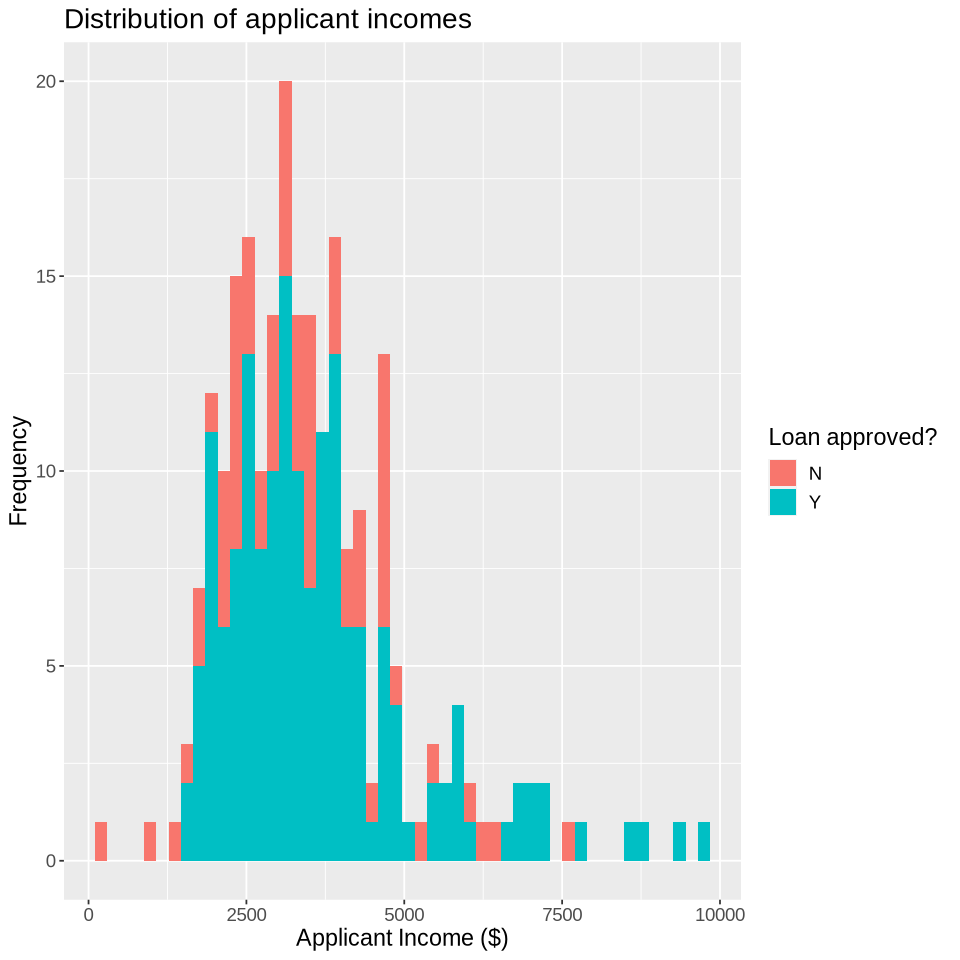

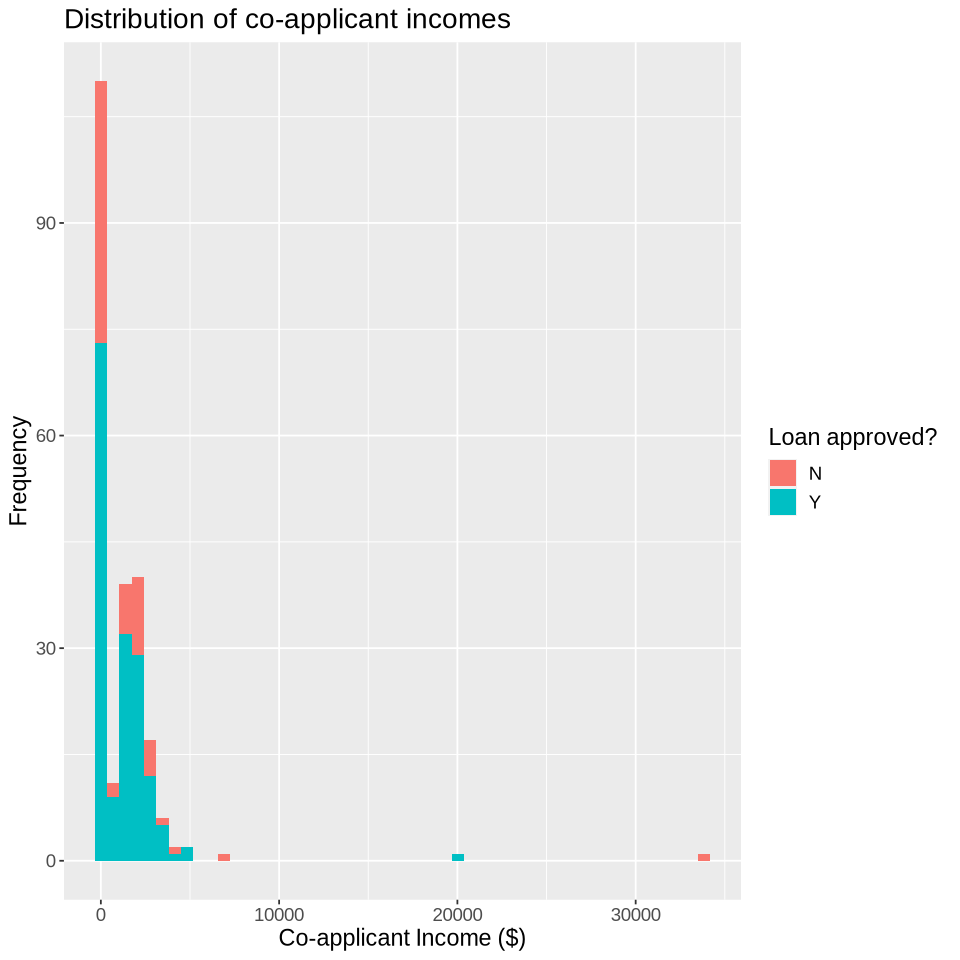

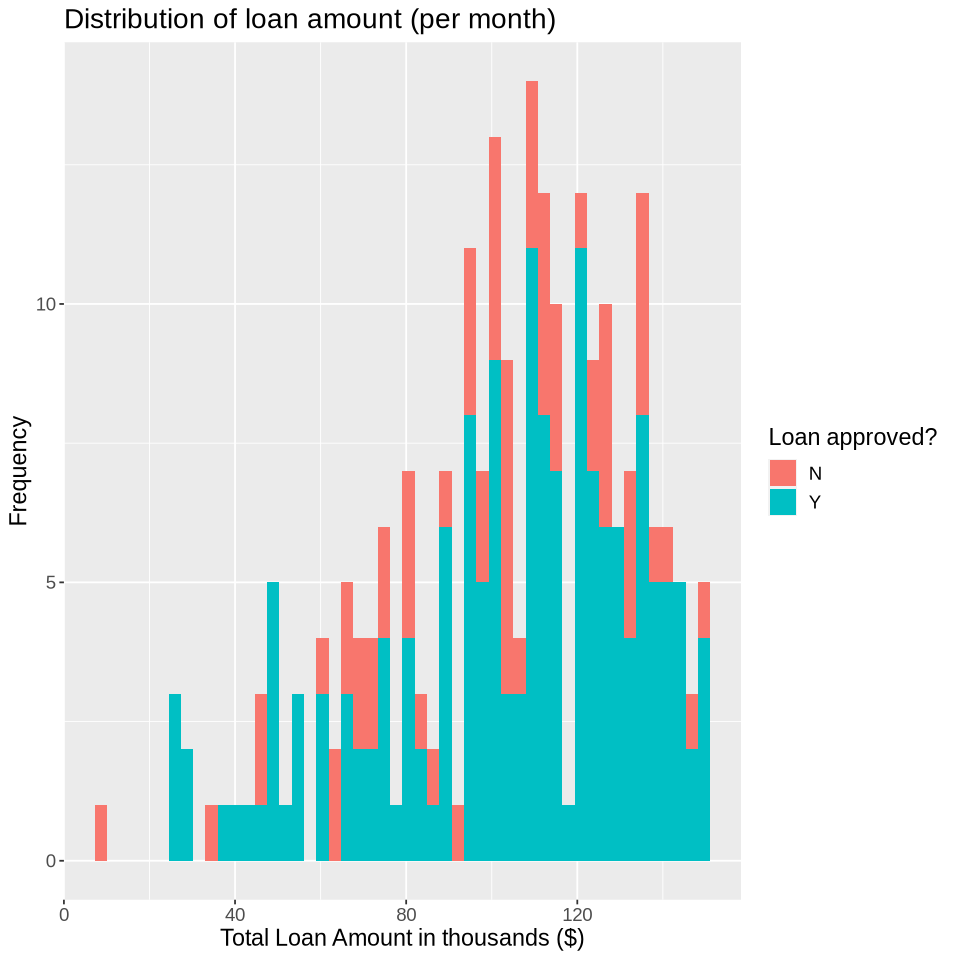

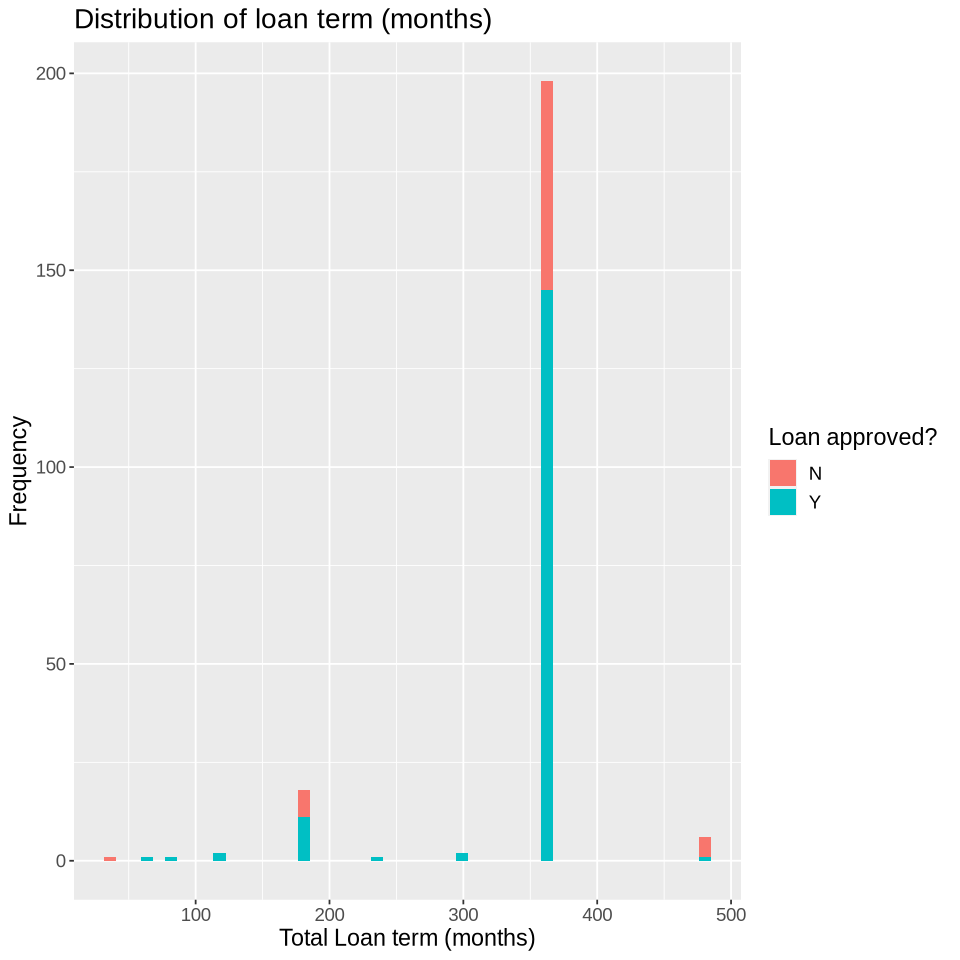

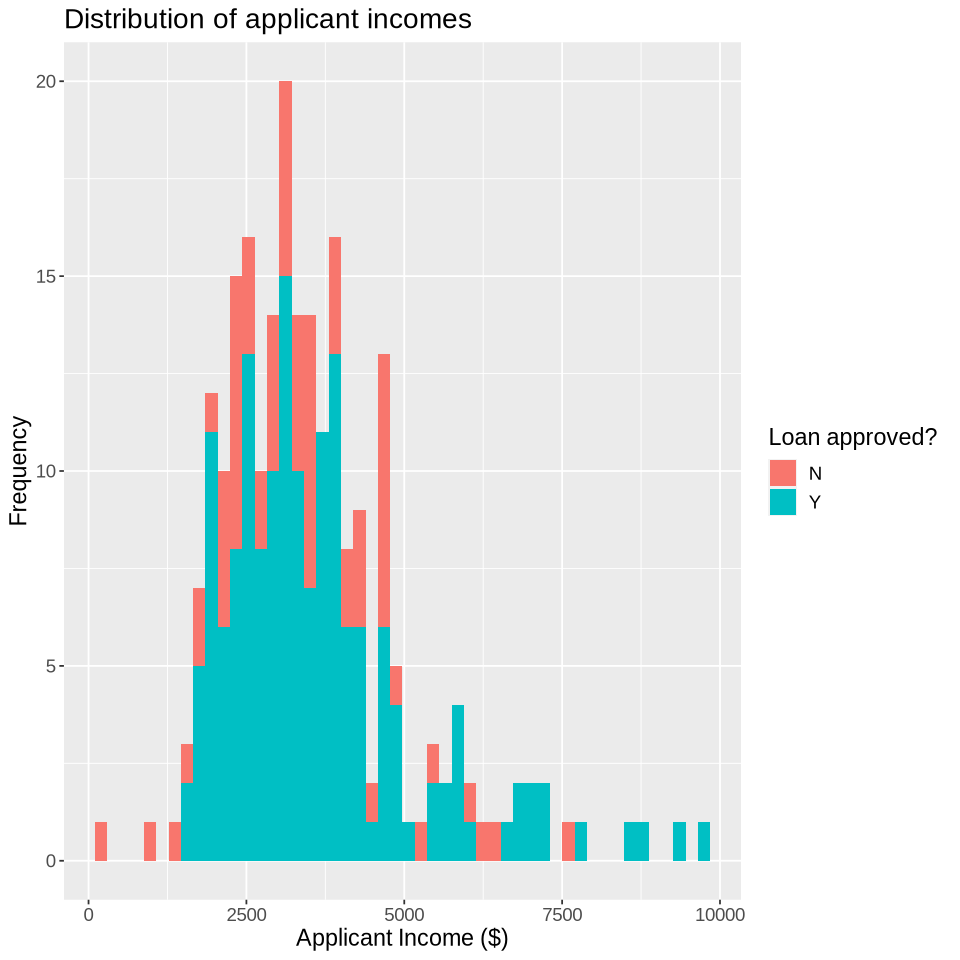

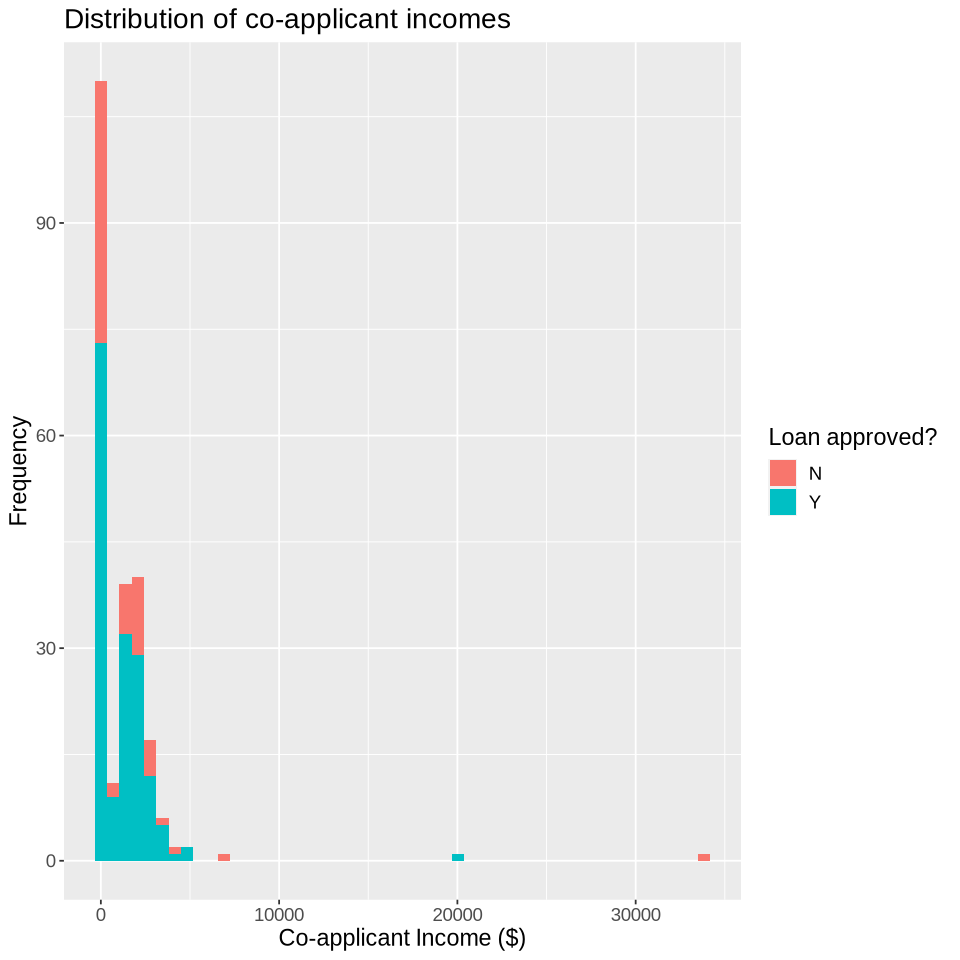

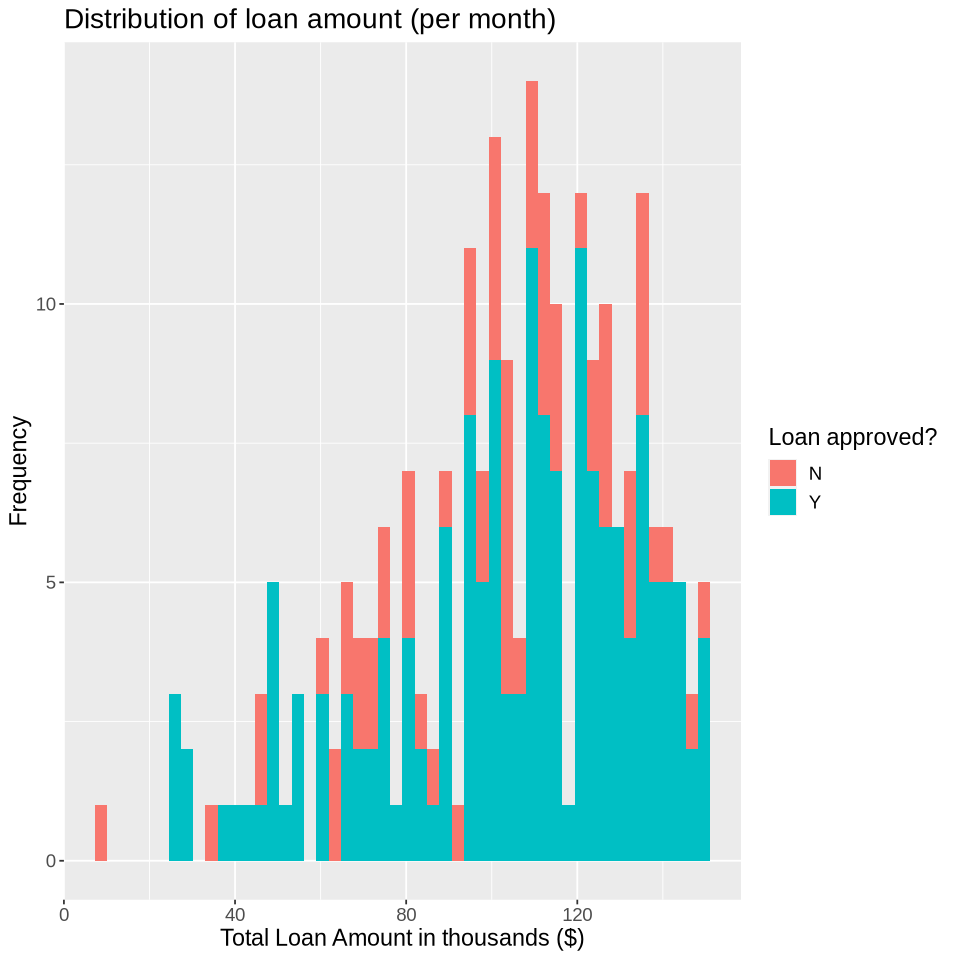

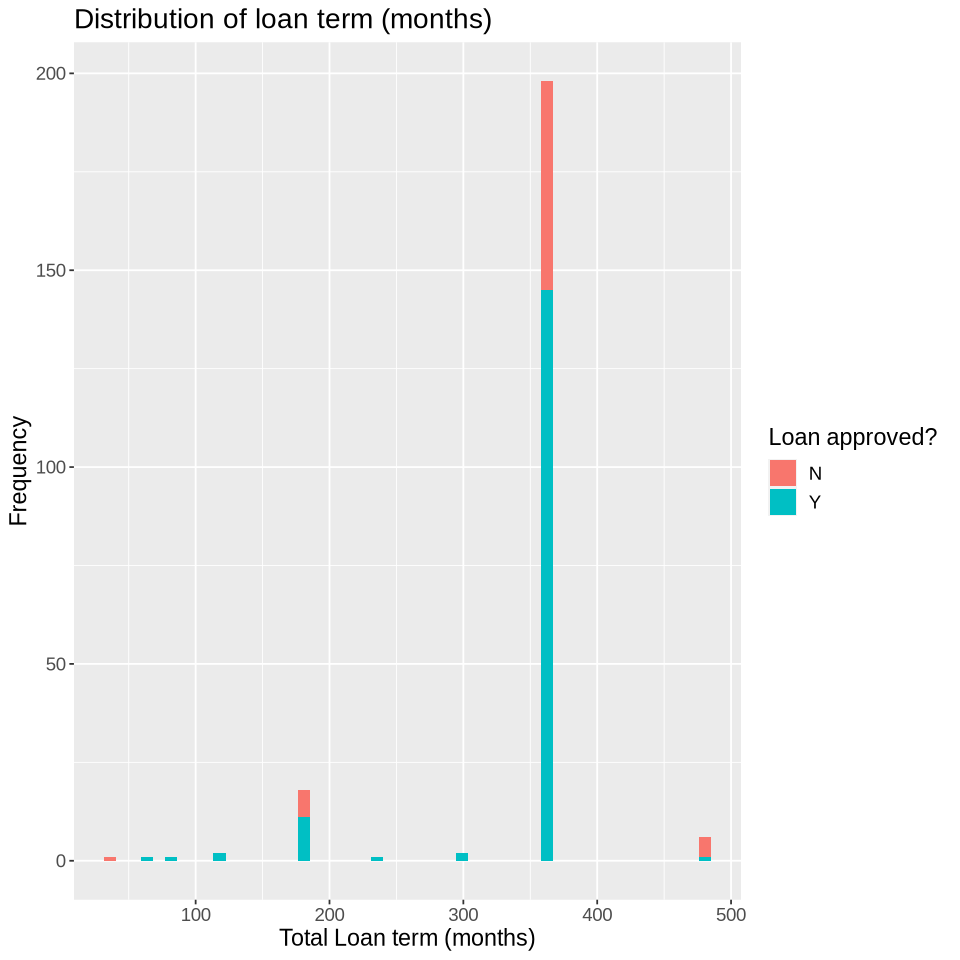

>>>>>>> remote


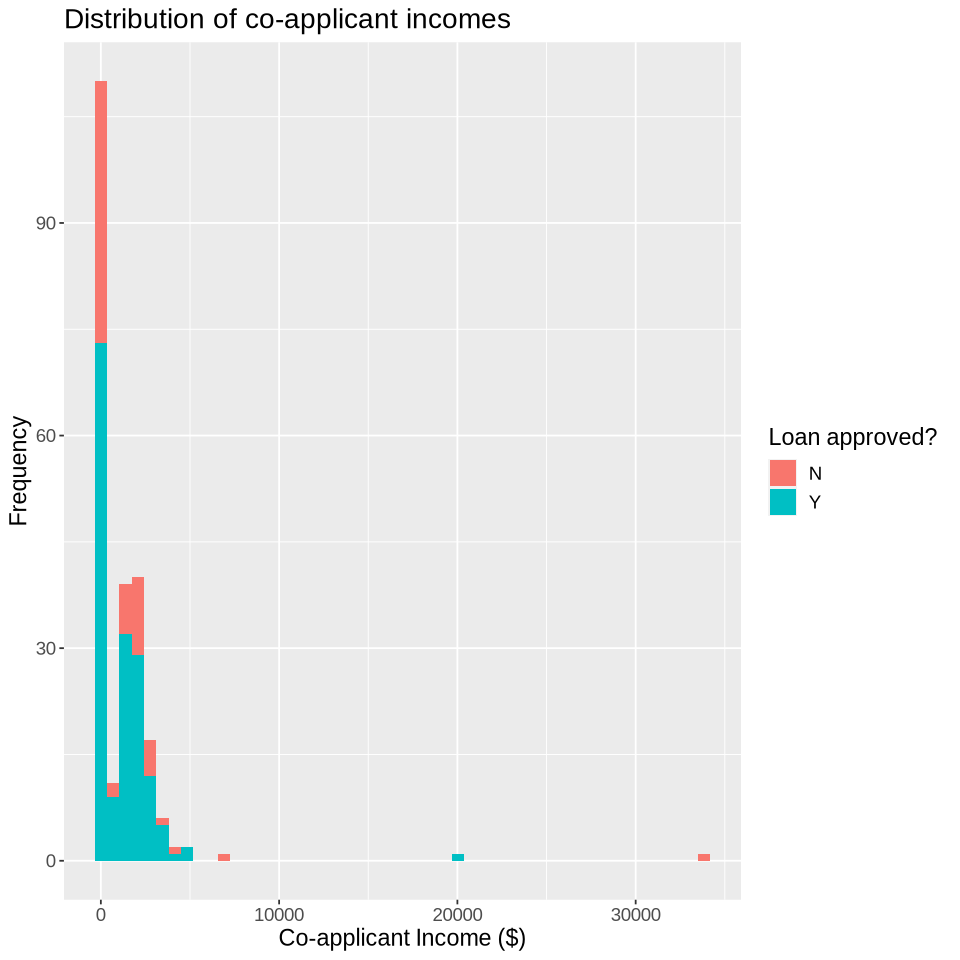

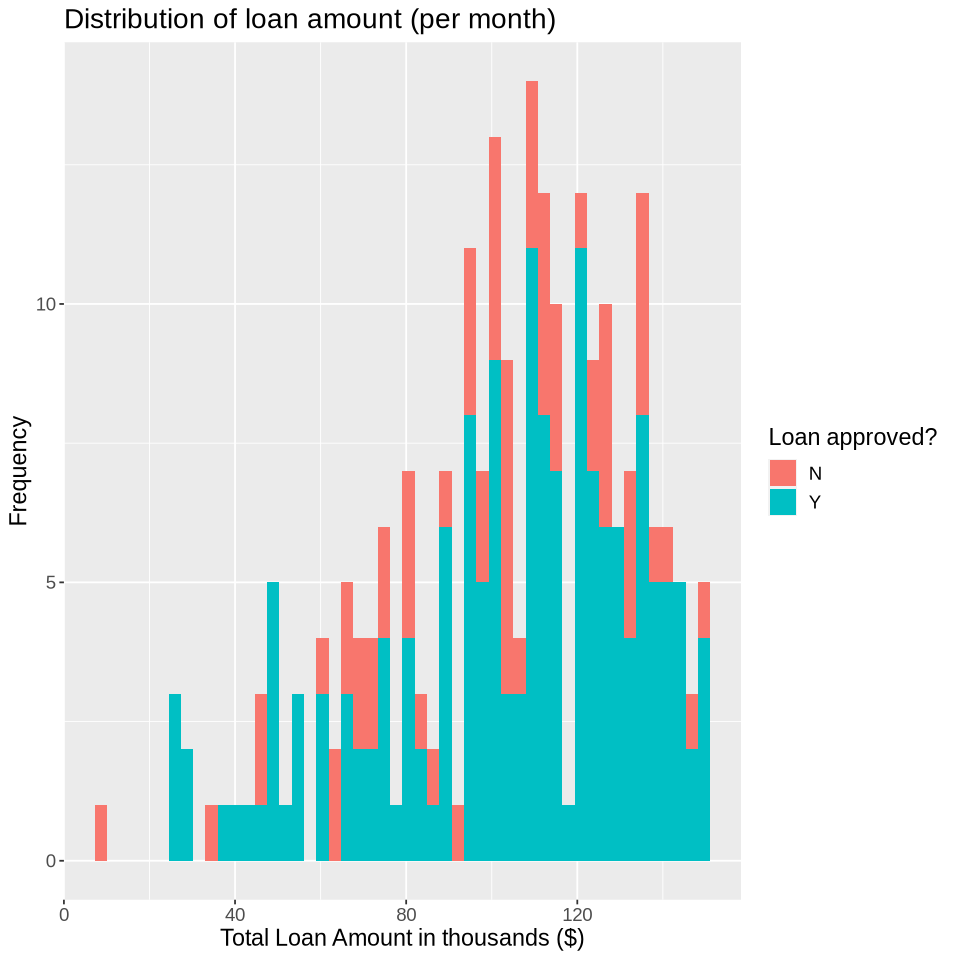

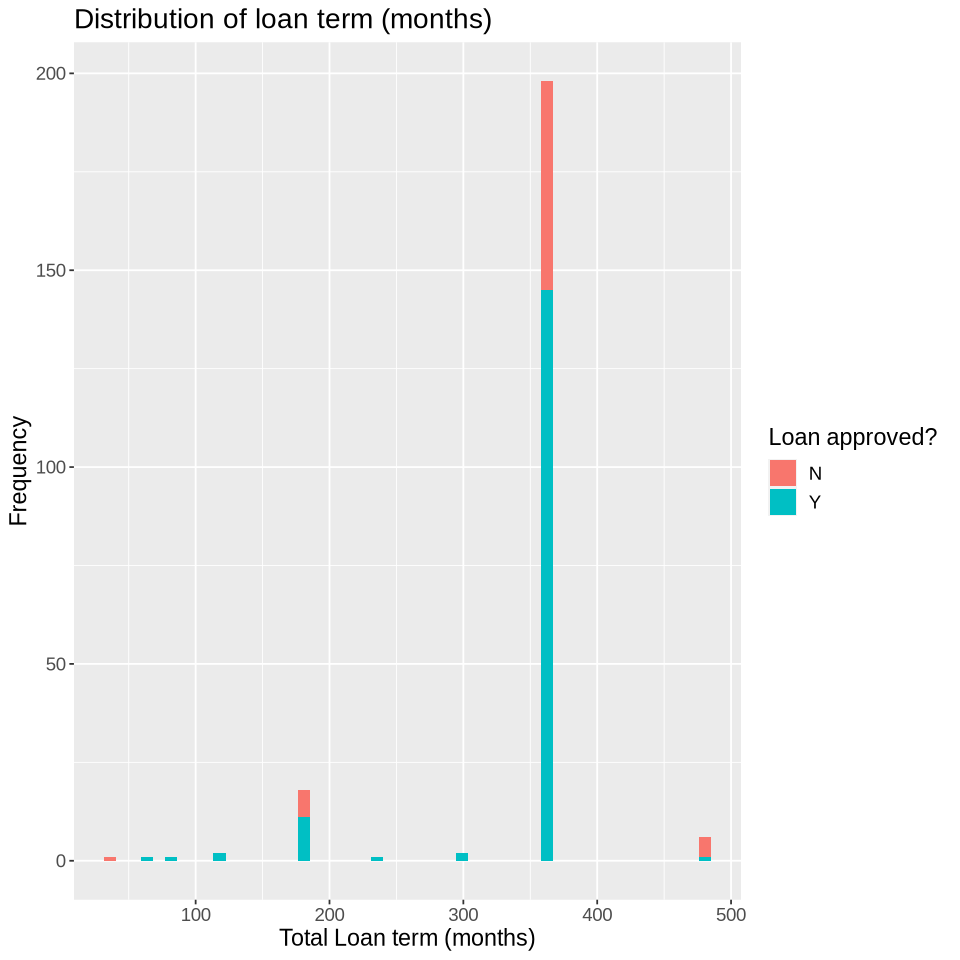

In [6]:
options(repr.plot.width=8, repr.plot.height=8)

income_dist_plot <- loan_train |>
    ggplot(aes(x=ApplicantIncome, fill=LoanStatus)) +
    geom_histogram(bins=50) +
    labs(title = "Distribution of applicant incomes", x = "Applicant Income ($)", y = "Frequency", fill="Loan approved?") +
    theme(text = element_text(size = 14))
income_dist_plot

coincome_dist_plot <- loan_train |>
    ggplot(aes(x=CoapplicantIncome, fill=LoanStatus)) +
    geom_histogram(bins=50) +
    labs(title = "Distribution of co-applicant incomes", x = "Co-applicant Income ($)", y = "Frequency", fill="Loan approved?") +
    theme(text = element_text(size = 14))
coincome_dist_plot

loan_amount_plot <- loan_train |>
    ggplot(aes(x=LoanAmount, fill=LoanStatus)) +
    geom_histogram(bins=50) +
    labs(title = "Distribution of loan amount (per month)", x = "Total Loan Amount in thousands ($)", y = "Frequency", fill="Loan approved?") +
    theme(text = element_text(size = 14))
loan_amount_plot

loan_term_plot <- loan_train |>
    ggplot(aes(x=LoanTerm, fill=LoanStatus)) +
    geom_histogram(bins=50) +
    labs(title = "Distribution of loan term (months)", x = "Total Loan term (months)", y = "Frequency", fill="Loan approved?") +
    theme(text = element_text(size = 14))
loan_term_plot

#### 5.2. Relationship between Income and Loan Amount

**Relationship Analysis:** To prepare for the KNN classification, it is necessary to explore the relationship between predictor variables and the response variable. The scatter plot `relationship_plot` should better demonstrate the relationship between `TotalIncome`, `TotalLoanAmount` and `LoanStatus`.

<<<<<<< local


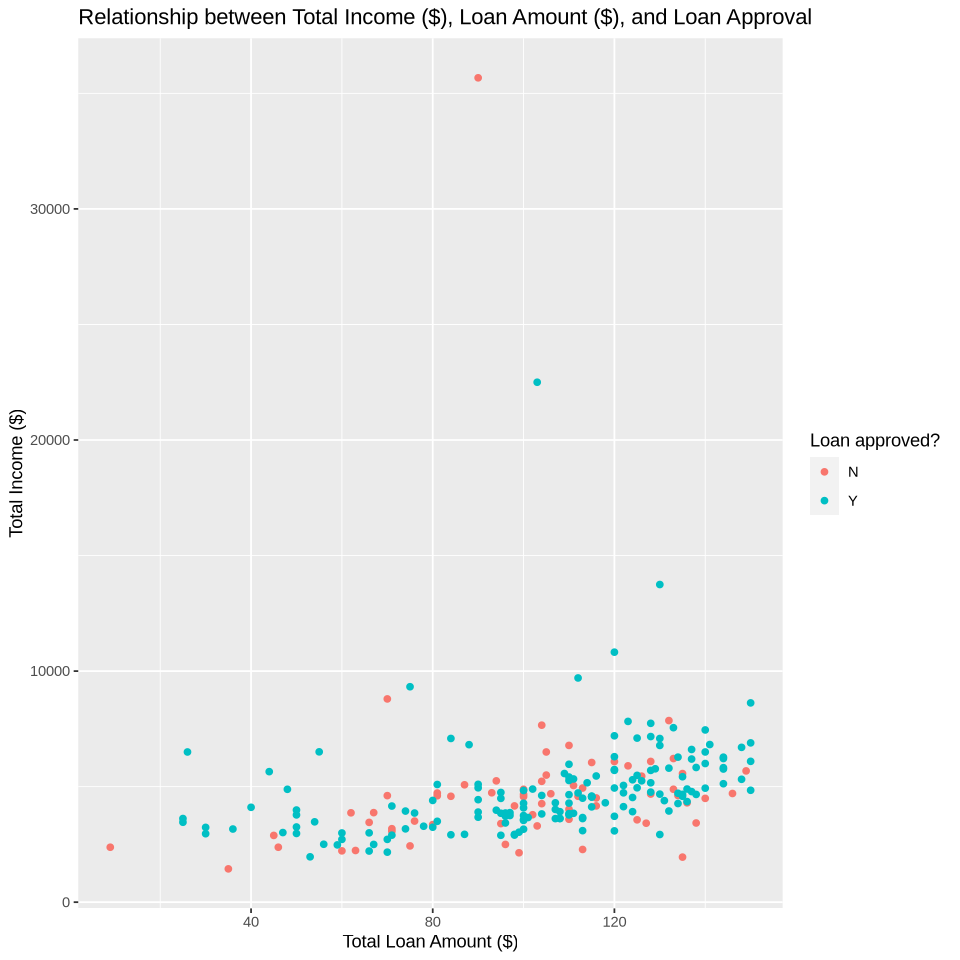

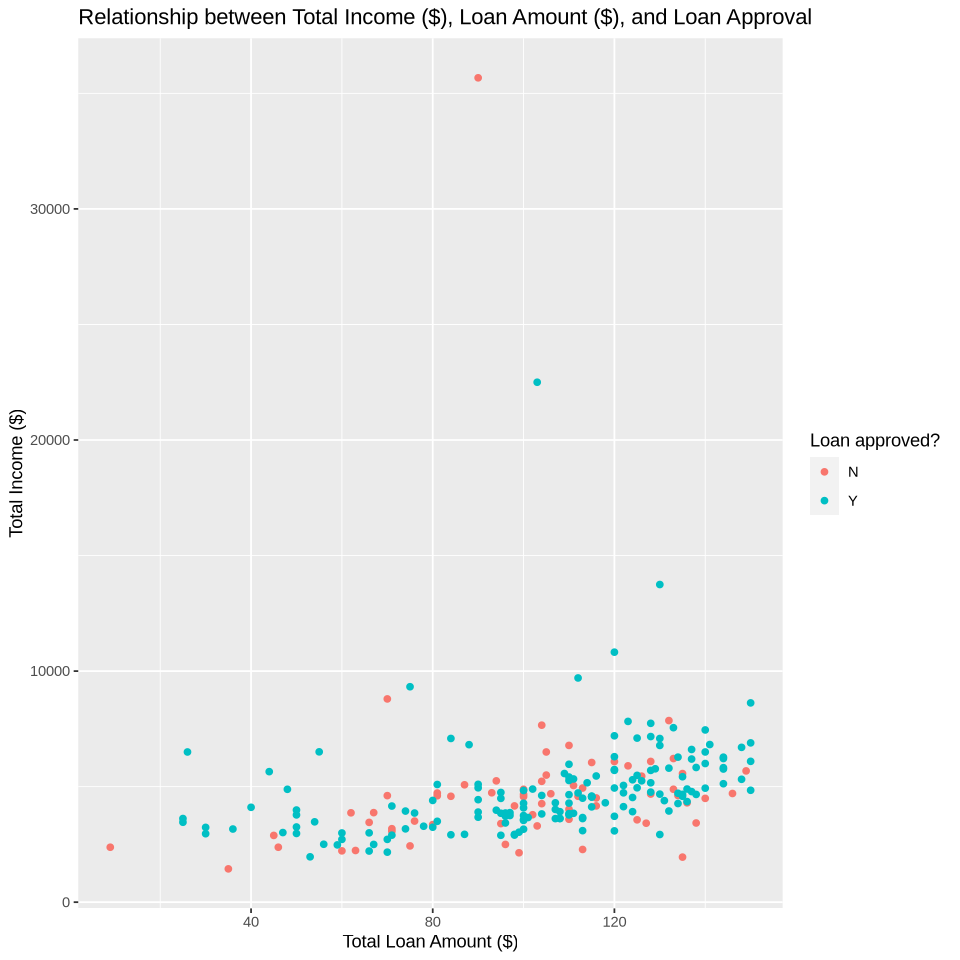

>>>>>>> remote


In [7]:
relationship_plot <- loan_train |>
    ggplot(aes(x=LoanAmount, y=TotalIncome, color=LoanStatus)) +
    geom_point() + 
    labs(title = "Relationship between Total Income ($), Loan Amount ($), and Loan Approval", x="Total Loan Amount ($)", y="Total Income ($)", color="Loan approved?")
relationship_plot

## Methods

 This project aims to use the following variables as predictors:
 - `ApplicantIncome`: Monthly income in dollars for the main applicant
 - `CoapplicantIncome`: Monthly income in dollars for any co-applicants in the main applicant's household
 - `LoanAmount`: Loan amount in thousands of dollars
 - `LoanTerm`: Loan term in months

In the preliminary data analysis, the data summary includes the number of occurrences for each class, and the mean values of the predictors intended to be used.

**(1)** There are almost twice as many positive `LoanStatus` class occurrences as negative ones. This will lead to a class imbalance that affects the classifier's performance. To solve this, either an upsample of the negative classes or a downsample of the positive classes will be necessary.

**(2)** The predictors intended to be used have largely the same mean values for both the positive and negative classes. This could be due to large variance or outliers within the predictors affecting the mean.

The visualizations created involve the distributions of the predictors intended to be used. From the visualizations, it is possible to see that there are some class imbalances for outlier values, especially in `Applicant/co-applicantIncome` and the `LoanTerm`. This could lead to poor classification for new observations near the outlier values and may need to be removed.

Other visualizations involving scatter plots of the relationships between predictors will be necessary. This will allow for determining if there is any clear grouping occurring, and to potentially determine which predictors are the most important in the classifier.

## Expected Outcomes and Significance

 - Since the model utilized will only include a smaller subset of predictors compared to the original dataset, findings can help others determine if their loan will be approved in a fast and simpler way rather than filling out large forms with a high volume of information.
 - Loan applicants can have a better idea of what income they should have when applying for a loan of a certain amount.
 - If the model creates a very accurate prediction, it may have some implications on the relationship between applicant income, loan amount, and loan approval status: if only those two variables alone can predict loan approval status in a reasonably accurate way, to what extent are applicant income and loan amount the most important factors for banks in determining loan approval status?
 - For larger loans, applicant income may become more important. So, does the variable of applicant income become more significant in determining loan approval status for more expensive loans?